**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on December 30th, 2023.

In [1]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl

## Set up the statsbombloader

In [3]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = StatsBombLoader(root=free_open_data_remote, getter="remote")

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
#datafolder = "../data-epl" # Example of local folder with statsbomb data
#SBL = statsbomb.StatsBombLoader(root=datafolder, getter="local")

## Select competitions to load and convert

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'1. Bundesliga',
 'Champions League',
 'Copa del Rey',
 "FA Women's Super League",
 'FIFA U20 World Cup',
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'Liga Profesional',
 'Ligue 1',
 'Major League Soccer',
 'NWSL',
 'North American League',
 'Premier League',
 'Serie A',
 'UEFA Euro',
 'UEFA Europa League',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [5]:
# Fifa world cup
selected_competitions = competitions[
    (competitions.competition_name == "FIFA World Cup")
    & (competitions.season_name == "2018")
]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
27,3,43,FIFA World Cup,International,male,2018


In [6]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,769,768,2018-07-03 20:00:00,1,1
1,768,782,2018-06-28 20:00:00,0,1
2,790,773,2018-07-03 16:00:00,1,0
3,797,780,2018-06-25 20:00:00,1,1
4,780,788,2018-06-20 14:00:00,1,0
...,...,...,...,...,...
59,796,774,2018-06-19 20:00:00,3,1
60,796,785,2018-07-07 20:00:00,2,2
61,776,771,2018-06-26 16:00:00,0,0
62,778,787,2018-06-24 17:00:00,2,2


## Load and convert match data

In [7]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
atomic_actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    
    # convert data
    actions = spadl.statsbomb.convert_to_actions(
        events, 
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|███████████████████████████████████████████████████████████████| 64/64 [01:21<00:00,  1.28s/it]


## Store converted spadl data in a h5-file

In [8]:
datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in atomic_actions.keys():
        spadlstore[f"atomic_actions/game_{game_id}"] = atomic_actions[game_id]

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [9]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"atomic_actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
del atomic_actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,7559,49d14d7d-f30d-4cc9-9782-a961b11cd858,1,0.100,774,5252.0,52.9375,33.575,66.9375,39.525,0,1,5,0
1,7559,34d412ca-9eec-4fc6-b62c-8f01b9767d63,1,1.033,774,3568.0,66.9375,39.525,66.9375,37.825,21,1,0,1
2,7559,d667b55f-f937-4e59-9df8-d69b482b1c3b,1,1.200,774,3568.0,66.9375,37.825,72.1875,61.625,0,1,5,2
3,7559,60c997a8-2d06-4551-8346-816c202a1042,1,2.653,774,5250.0,72.1875,61.625,72.1875,60.775,21,1,0,3
4,7559,6679ad75-0833-4062-b4de-5367e262afa7,1,3.800,774,5250.0,72.1875,60.775,84.4375,49.725,0,1,5,4


2018-07-14 16:00:00 Belgium 2-0 England 4'


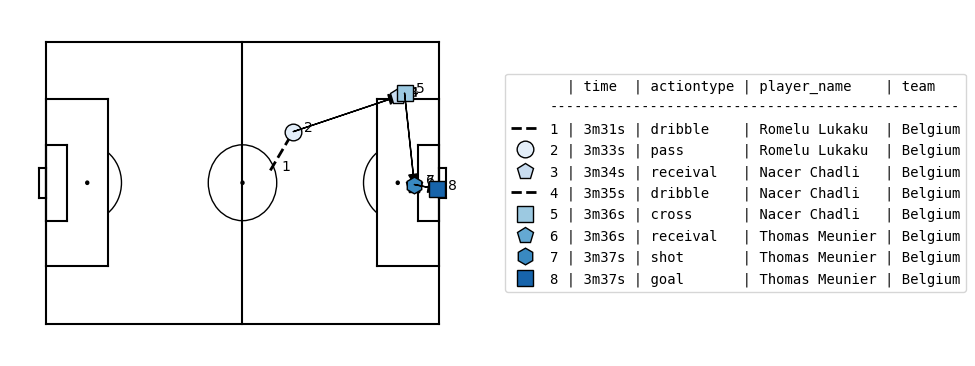

2018-07-14 16:00:00 Belgium 2-0 England 82'


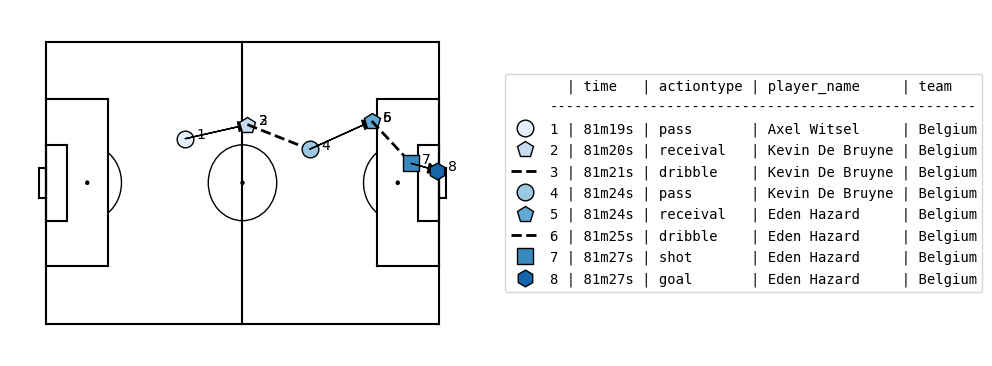

In [10]:
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )